# Objective 
- Predict the likelihood of a loan to be defaulted

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import sys

import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(threshold=sys.maxsize)

# Sets column width to show full information
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Sets describe function to show full numerical value
pd.set_option('float_format', '{:f}'.format)

# Read Data for Modelling

In [2]:
# Read data into a dataframe
df = pd.read_excel('../data/loans.xlsx')
df.head(5)

,ID,UEN Black Listed,SSIC,Industry,Loan ID,Product,Amount,Disbursal Amount,Insured,Disbursal Fee,Payment Amount,Due Date,Weekday,Day,Month,Year,Payment_Num,Defaulted,Is Paid,Loan Status,Funding Date,Expected First Payment Date,Interest Rate,Tenor,Status,Delinquent,Delinquent Amount,Date of First Delinquency,First Payment Date
0,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-09-04,7,4,9,2016,1,0,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04
1,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-08-04,4,4,8,2016,2,1,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04
2,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-07-04,1,4,7,2016,3,0,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04
3,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-06-04,6,4,6,2016,4,0,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04
4,1000513,1,46900,Wholesale trade of a variety of goods without a dominant product,484,1,100000.000000,99000.000000,0,1000.000000,18166.670000,2016-05-04,3,4,5,2016,5,0,1,Repaid in Full,2016-03-04,2016-04-09,1.500000,6,Closed - Obligations met,0,0.000000,2016-08-04 00:00:00,2016-04-04


In [3]:
df.describe()

,ID,UEN Black Listed,SSIC,Loan ID,Product,Amount,Disbursal Amount,Insured,Disbursal Fee,Payment Amount,Weekday,Day,Month,Year,Payment_Num,Defaulted,Is Paid,Interest Rate,Tenor,Delinquent,Delinquent Amount
count,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000,24880.000000
mean,1000712.637621,0.089831,42100.657154,17866.430466,2.885772,44188.112739,43238.659007,0.484847,902.396158,29095.601730,3.800000,16.881632,6.419453,2020.175080,2.178979,0.158883,0.351728,1.142463,5.944695,0.212138,1840.986955
std,453.438268,0.285946,17284.025994,6885.534304,1.284915,70414.889429,69361.516974,0.499780,1744.833779,62213.187882,2.061622,9.120019,3.469705,1.176483,2.889556,0.365574,0.477519,0.597468,3.598415,0.408830,16142.284296
min,1000008.000000,0.000000,1111.000000,484.000000,1.000000,200.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2016.000000,1.000000,0.000000,0.000000,0.400000,1.000000,0.000000,0.000000
25%,1000261.000000,0.000000,30110.000000,11948.750000,2.000000,6000.000000,5955.060000,0.000000,44.100000,4584.000000,2.000000,9.000000,3.000000,2019.000000,1.000000,0.000000,0.000000,0.670000,4.000000,0.000000,0.000000
50%,1000679.000000,0.000000,30110.000000,18307.000000,4.000000,19100.000000,18793.450000,0.000000,156.000000,9455.960000,4.000000,17.000000,6.000000,2020.000000,1.000000,0.000000,0.000000,0.800000,5.000000,0.000000,0.000000
75%,1001132.000000,0.000000,47712.000000,23846.250000,4.000000,50000.000000,49767.580000,1.000000,865.500000,26100.500000,6.000000,25.000000,9.000000,2021.000000,1.000000,0.000000,1.000000,1.500000,5.000000,0.000000,0.000000
max,1001473.000000,1.000000,96099.000000,28932.000000,6.000000,1150000.000000,1145078.000000,1.000000,25000.000000,1166100.000000,7.000000,31.000000,12.000000,2023.000000,24.000000,1.000000,1.000000,3.000000,24.000000,1.000000,537500.000000


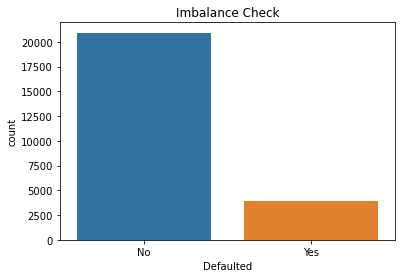

In [4]:
chart = sns.countplot(x=df['Defaulted'])

chart.set_xticklabels(['No','Yes'])
plt.title("Imbalance Check")
plt.show()

In [5]:
df['Defaulted'].value_counts()

0    20927
1     3953
Name: Defaulted, dtype: int64

## Over & Under Sampling Strategy

In [6]:
# Prepare Dataframe
df2 = df[['SSIC', 
          'Product',
          'Weekday',
          'Day',
          'Month',
          'Year',
          'Tenor',
          'Interest Rate',
          'Amount', 
          'Disbursal Amount', 
          'Payment Amount',
          'Insured', 
          'Defaulted'
         ]]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24880 entries, 0 to 24879
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SSIC              24880 non-null  int64  
 1   Product           24880 non-null  int64  
 2   Weekday           24880 non-null  int64  
 3   Day               24880 non-null  int64  
 4   Month             24880 non-null  int64  
 5   Year              24880 non-null  int64  
 6   Tenor             24880 non-null  int64  
 7   Interest Rate     24880 non-null  float64
 8   Amount            24880 non-null  float64
 9   Disbursal Amount  24880 non-null  float64
 10  Payment Amount    24880 non-null  float64
 11  Insured           24880 non-null  int64  
 12  Defaulted         24880 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 2.5 MB


In [7]:
# Step 1: Split into training & testing sets
X = df2.drop(columns = 'Defaulted')
y = df2['Defaulted']

In [8]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Over Sampling
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

print(f"Over-sampling: {Counter(y_ros)}")

# Under Sampling
rus = RandomUnderSampler() 
X_rus, y_rus = rus.fit_resample(X, y)
print(f"Under-sampling: {Counter(y_rus)}")


# Over & Under Sampling Mix
over = RandomOverSampler()
under = RandomUnderSampler()

# apply oversampling to minority class
X_over, y_over = over.fit_resample(X, y)

# combine undersampling 
X_cs, y_cs = under.fit_resample(X_over, y_over)


print(f"Combined Random Sampling: {Counter(y_cs)}")
print(Counter(y_ros))

Over-sampling: Counter({0: 20927, 1: 20927})
Under-sampling: Counter({0: 3953, 1: 3953})
Combined Random Sampling: Counter({0: 20927, 1: 20927})
Counter({0: 20927, 1: 20927})


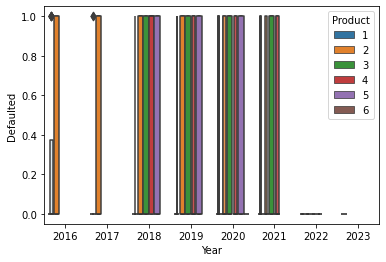

In [9]:
sns.boxenplot(x='Year',
             y='Defaulted',
              hue='Product',
             data=df2);

## Logistic Regression Model

In [10]:
# Import train_test_split.
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Evaluation tools
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

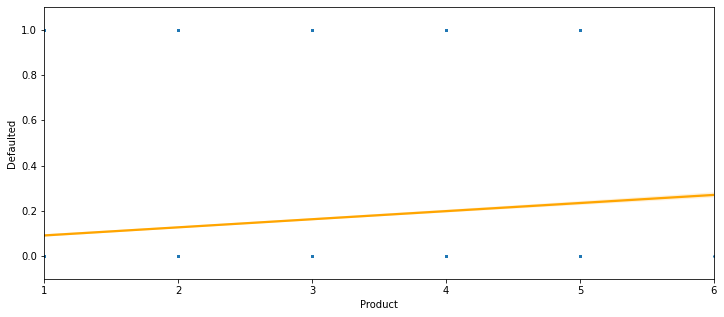

In [11]:
plt.figure(figsize = (12, 5))
sns.regplot(data=df2,
            x='Product', 
            y='Defaulted',
            #ci = false, 
            scatter_kws = {'s': 2},
            line_kws = {'color': 'orange'})
plt.ylim(-0.1, 1.1);

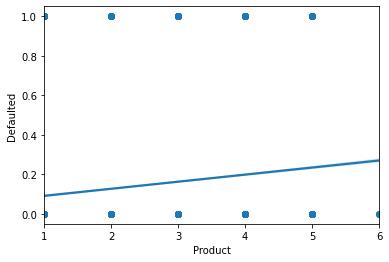

In [12]:
ax = sns.regplot(x="Product", y="Defaulted", data=df2)

In [13]:
print("Logistic Regression")
print("========================")

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30,
                                                    train_size=0.70,
                                                    random_state = 42)

# Instantiate our model.
lr = LogisticRegression(class_weight = "balanced")

# Fit our model.
lr.fit(X_train, y_train)

print(f'Intercept: {lr.intercept_}')
print("Coefficient: ")
print(lr.coef_)
print("========================")

# Get predictions
preds = lr.predict(X_test)
prob = np.round(lr.predict_proba(X_test), 3)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Calculate Specificity
spec = tn / (tn + fp)

# Calculate Precision
precision = tp / (tp+fp)

# Calculate Recall
recall = tp / (tp+fn)

# Print results
# Step 5: Evaluate model.

print(f'Training Score: {np.round(lr.score(X_train, y_train),3)}')
print(f'Test Score:     {np.round(lr.score(X_test, y_test),3)}')
print("========================")
print(f'Specificity:     {np.round(spec,3)}')
print(f'Precision:       {np.round(precision,3)}')
print(f'Recall:          {np.round(recall,3)}')
print(f'Accuracy Score:  {np.round(accuracy_score(y_test, preds),3)}')
print(f'F1:              {np.round(2*((precision*recall)/(precision+recall)),3)}')
print("========================")
print(f'True Negatives:  {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives:  {tp}')


Logistic Regression
Intercept: [8.00091617e-08]
Coefficient: 
[[-4.35713257e-06  9.52160126e-07  3.17276089e-07  5.57932676e-06
  -5.23006512e-07  1.58158875e-04 -4.11113387e-06  3.05147357e-07
  -3.16742534e-05  9.88862418e-06  2.23012599e-05  1.26891166e-07]]
Training Score: 0.378
Test Score:     0.369
Specificity:     0.266
Precision:       0.192
Recall:          0.908
Accuracy Score:  0.369
F1:              0.316
True Negatives:  1667
False Positives: 4597
False Negatives: 111
True Positives:  1089


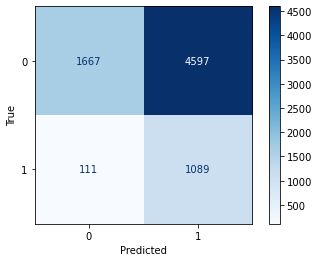

In [14]:
# View confusion matrix

plot_confusion_matrix(lr, X_test, y_test, cmap='Blues', values_format='d');
#plt.title("Logistic Regression - Test Results")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Baseline: ROC AUC=0.500
LogisticRegression: ROC AUC=0.612


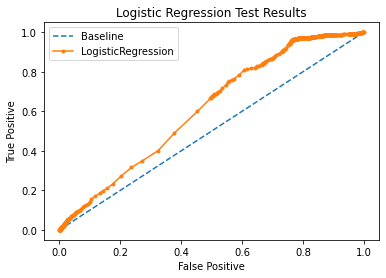

In [15]:
# ROC Curve

base_probs = [0 for _ in range(len(y_test))]
model_probs = prob[:,1]

# Calculate scores
base_auc = roc_auc_score(y_test, base_probs)
auc = roc_auc_score(y_test, model_probs)

# Summarize scores
print('Baseline: ROC AUC=%.3f' % (base_auc))
print('LogisticRegression: ROC AUC=%.3f' % (auc))

# Calculate roc curves
base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)
model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)

# Plot roc curve for the model
plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')
plt.plot(model_fpr, model_tpr, marker='.', label='LogisticRegression')

# Title
plt.title('Logistic Regression Test Results')

# Axis labels
plt.xlabel('False Positive')
plt.ylabel('True Positive')

# Legend
plt.legend()

plt.show()


In [39]:
print("Logistic Regression: Under-Sampling")
print("========================")

X_train, X_test, y_train, y_test = train_test_split(X_rus, 
                                                    y_rus, 
                                                    test_size=0.30,
                                                    train_size=0.70,
                                                    random_state = 42)

# Instantiate our model.
lr = LogisticRegression()

# Fit our model.
lr.fit(X_train, y_train)

print(f'Intercept: {lr.intercept_}')
print("Coefficient: ")
print(lr.coef_)
print("========================")

# Get predictions
preds = lr.predict(X_test)
prob = np.round(lr.predict_proba(X_test), 3)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Calculate Specificity
spec = tn / (tn + fp)

# Calculate Precision
precision = tp / (tp+fp)

# Calculate Recall
recall = tp / (tp+fn)

# Print results
# Step 5: Evaluate model.

print(f'Training Score: {np.round(lr.score(X_train, y_train),3)}')
print(f'Test Score:     {np.round(lr.score(X_test, y_test),3)}')
print("========================")
print(f'Specificity:     {np.round(spec,3)}')
print(f'Precision:       {np.round(precision,3)}')
print(f'Recall:          {np.round(recall,3)}')
print(f'Accuracy Score:  {np.round(accuracy_score(y_test, preds),3)}')
print(f'F1:              {np.round(2*((precision*recall)/(precision+recall)),3)}')
print("========================")
print(f'True Negatives:  {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives:  {tp}')

Logistic Regression: Under-Sampling
Intercept: [8.19869548e-05]
Coefficient: 
[[-5.29048948e-06  2.70752176e-02  1.03042699e-02  1.06658181e-02
  -7.87692638e-02  7.16394712e-04 -1.90309594e-01  1.20789981e-02
   2.72222902e-05 -3.40435703e-05  5.95394959e-06  7.51155431e-03]]
Training Score: 0.604
Test Score:     0.606
Specificity:     0.468
Precision:       0.578
Recall:          0.747
Accuracy Score:  0.606
F1:              0.652
True Negatives:  562
False Positives: 639
False Negatives: 296
True Positives:  875


C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


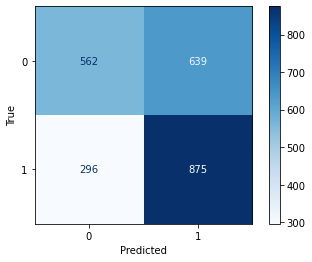

In [17]:
# View confusion matrix

plot_confusion_matrix(lr, X_test, y_test, cmap='Blues', values_format='d');
#plt.title("Logistic Regression - Test Results")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Baseline: ROC AUC=0.500
LogisticRegression: ROC AUC=0.649


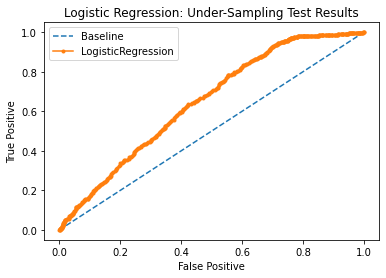

In [18]:
# ROC Curve

base_probs = [0 for _ in range(len(y_test))]
model_probs = prob[:,1]

# Calculate scores
base_auc = roc_auc_score(y_test, base_probs)
auc = roc_auc_score(y_test, model_probs)

# Summarize scores
print('Baseline: ROC AUC=%.3f' % (base_auc))
print('LogisticRegression: ROC AUC=%.3f' % (auc))

# Calculate roc curves
base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)
model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)

# Plot roc curve for the model
plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')
plt.plot(model_fpr, model_tpr, marker='.', label='LogisticRegression')

# Title
plt.title('Logistic Regression: Under-Sampling Test Results')

# Axis labels
plt.xlabel('False Positive')
plt.ylabel('True Positive')

# Legend
plt.legend()

plt.show()


In [19]:
print("Logistic Regression: Over-Sampling")
print("========================")

X_train, X_test, y_train, y_test = train_test_split(X_ros, 
                                                    y_ros, 
                                                    test_size=0.30,
                                                    train_size=0.70,
                                                    random_state = 42)

# Instantiate our model.
lr = LogisticRegression()

# Fit our model.
lr.fit(X_train, y_train)

print(f'Intercept: {lr.intercept_}')
print("Coefficient: ")
print(lr.coef_)
print("========================")

# Get predictions
preds = lr.predict(X_test)
prob = np.round(lr.predict_proba(X_test), 3)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Calculate Specificity
spec = tn / (tn + fp)

# Calculate Precision
precision = tp / (tp+fp)

# Calculate Recall
recall = tp / (tp+fn)

# Print results
# Step 5: Evaluate model.

print(f'Training Score: {np.round(lr.score(X_train, y_train),3)}')
print(f'Test Score:     {np.round(lr.score(X_test, y_test),3)}')
print("========================")
print(f'Specificity:     {np.round(spec,3)}')
print(f'Precision:       {np.round(precision,3)}')
print(f'Recall:          {np.round(recall,3)}')
print(f'Accuracy Score:  {np.round(accuracy_score(y_test, preds),3)}')
print(f'F1:              {np.round(2*((precision*recall)/(precision+recall)),3)}')
print("========================")
print(f'True Negatives:  {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives:  {tp}')

Logistic Regression: Over-Sampling
Intercept: [7.63832903e-08]
Coefficient: 
[[-4.34644508e-06  4.41937429e-07  2.86053429e-07  2.28620169e-06
   1.90127135e-07  1.53336836e-04 -8.08294824e-07  1.13411163e-07
  -1.28103066e-05 -9.24075138e-06  2.27674266e-05  9.14681936e-08]]
Training Score: 0.596
Test Score:     0.589
Specificity:     0.268
Precision:       0.552
Recall:          0.913
Accuracy Score:  0.589
F1:              0.688
True Negatives:  1693
False Positives: 4627
False Negatives: 540
True Positives:  5697


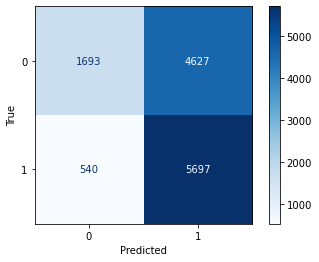

In [20]:
# View confusion matrix

plot_confusion_matrix(lr, X_test, y_test, cmap='Blues', values_format='d');
#plt.title("Logistic Regression - Test Results")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Baseline: ROC AUC=0.500
LogisticRegression: ROC AUC=0.617


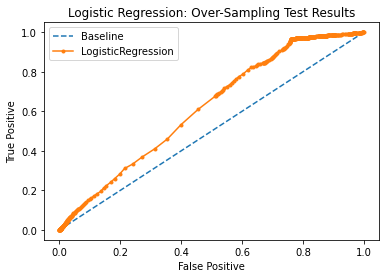

In [21]:
# ROC Curve

base_probs = [0 for _ in range(len(y_test))]
model_probs = prob[:,1]

# Calculate scores
base_auc = roc_auc_score(y_test, base_probs)
auc = roc_auc_score(y_test, model_probs)

# Summarize scores
print('Baseline: ROC AUC=%.3f' % (base_auc))
print('LogisticRegression: ROC AUC=%.3f' % (auc))

# Calculate roc curves
base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)
model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)

# Plot roc curve for the model
plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')
plt.plot(model_fpr, model_tpr, marker='.', label='LogisticRegression')

# Title
plt.title('Logistic Regression: Over-Sampling Test Results')

# Axis labels
plt.xlabel('False Positive')
plt.ylabel('True Positive')

# Legend
plt.legend()

plt.show()


In [22]:
print("Logistic Regression - Over/Under Sampling Mix")
print("========================")

X_train, X_test, y_train, y_test = train_test_split(X_cs, 
                                                    y_cs, 
                                                    test_size=0.30,
                                                    train_size=0.70,
                                                    random_state = 42)

# Instantiate our model.
lr = LogisticRegression()

# Fit our model.
lr.fit(X_train, y_train)

print(f'Intercept: {lr.intercept_}')
print("Coefficient: ")
print(lr.coef_)
print("========================")

# Get predictions
preds = lr.predict(X_test)
prob = np.round(lr.predict_proba(X_test), 3)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Calculate Specificity
spec = tn / (tn + fp)

# Calculate Precision
precision = tp / (tp+fp)

# Calculate Recall
recall = tp / (tp+fn)

# Print results
# Step 5: Evaluate model.

print(f'Training Score: {np.round(lr.score(X_train, y_train),3)}')
print(f'Test Score:     {np.round(lr.score(X_test, y_test),3)}')
print("========================")
print(f'Specificity:     {np.round(spec,3)}')
print(f'Precision:       {np.round(precision,3)}')
print(f'Recall:          {np.round(recall,3)}')
print(f'Accuracy Score:  {np.round(accuracy_score(y_test, preds),3)}')
print(f'F1:              {np.round(2*((precision*recall)/(precision+recall)),3)}')
print("========================")
print(f'True Negatives:  {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives:  {tp}')

Logistic Regression - Over/Under Sampling Mix
Intercept: [7.34252111e-08]
Coefficient: 
[[-4.06310548e-06  9.26544578e-07  4.00594920e-07  4.40091336e-06
  -9.04710960e-07  1.44668977e-04 -4.02523630e-06  2.45859710e-07
  -3.47254272e-05  1.43783119e-05  2.12153880e-05  2.16298477e-07]]
Training Score: 0.59
Test Score:     0.594
Specificity:     0.275
Precision:       0.556
Recall:          0.914
Accuracy Score:  0.594
F1:              0.691
True Negatives:  1734
False Positives: 4567
False Negatives: 537
True Positives:  5719


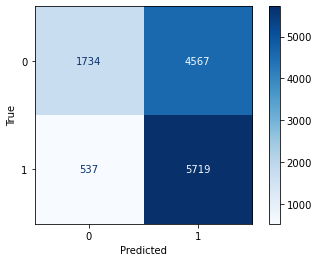

In [23]:
# View confusion matrix

plot_confusion_matrix(lr, X_test, y_test, cmap='Blues', values_format='d');
#plt.title("Logistic Regression - Test Results")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Baseline: ROC AUC=0.500
LogisticRegression: ROC AUC=0.624


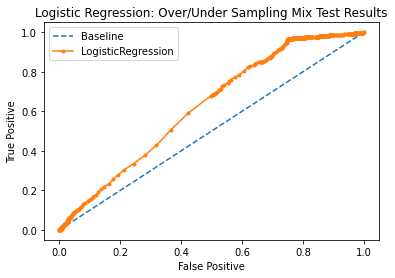

In [24]:
# ROC Curve

base_probs = [0 for _ in range(len(y_test))]
model_probs = prob[:,1]

# Calculate scores
base_auc = roc_auc_score(y_test, base_probs)
auc = roc_auc_score(y_test, model_probs)

# Summarize scores
print('Baseline: ROC AUC=%.3f' % (base_auc))
print('LogisticRegression: ROC AUC=%.3f' % (auc))

# Calculate roc curves
base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)
model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)

# Plot roc curve for the model
plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')
plt.plot(model_fpr, model_tpr, marker='.', label='LogisticRegression')

# Title
plt.title('Logistic Regression: Over/Under Sampling Mix Test Results')

# Axis labels
plt.xlabel('False Positive')
plt.ylabel('True Positive')

# Legend
plt.legend()

plt.show()


## Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier


In [26]:
print("Decision Tree Classifier")
print("========================")

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20,
                                                    train_size=0.80,
                                                    random_state = 42)

#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state=42)
#X_sm, y_sm = sm.fit_resample(X_train, y_train)


# Instantiate model with random_state = 42
dt = DecisionTreeClassifier(class_weight = {0:0.25 , 1:0.75})

#dt = DecisionTreeClassifier(max_depth = 5,
#                            min_samples_split = 7,
#                            min_samples_leaf = 3,
#                            ccp_alpha = 0.01,
#                            random_state = 42)

# Fit model.
dt.fit(X_train, y_train)

# Get predictions
preds = dt.predict(X_test)
prob = np.round(dt.predict_proba(X_test), 3)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Calculate Specificity
spec = tn / (tn + fp)

# Calculate Precision
precision = tp / (tp+fp)

# Calculate Sensitivity
sensitivity = tp / (tp+fn)

# Print results
# Step 5: Evaluate model.

print(f'Training Score: {np.round(dt.score(X_train, y_train),3)}')
print(f'Test Score:     {np.round(dt.score(X_test, y_test),3)}')
print("========================")
print(f'Specificity:     {np.round(spec,3)}')
print(f'Precision:       {np.round(precision,3)}')
print(f'Sensitivity:     {np.round(sensitivity,3)}')
print(f'Accuracy Score:  {np.round(accuracy_score(y_test, preds),3)}')
print(f'F1:              {np.round(2*((precision*recall)/(precision+recall)),3)}')
print("========================")
print(f'True Negatives:  {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives:  {tp}')

Decision Tree Classifier
Training Score: 0.997
Test Score:     0.835
Specificity:     0.899
Precision:       0.491
Sensitivity:     0.506
Accuracy Score:  0.835
F1:              0.639
True Negatives:  3750
False Positives: 422
False Negatives: 397
True Positives:  407


In [27]:
grid = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'max_depth': [2, 3, 5, 7],
                                  'min_samples_split': [5, 10, 15, 20],
                                  'min_samples_leaf': [2, 3, 4, 5, 6],
                                  'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10]},
                    cv = 5,
                    verbose = 1)

In [28]:
import time

# Start our timer.
t0 = time.time()

# Let's GridSearch over the above parameters on our training data.
grid.fit(X_train, y_train)

# Stop our timer and print the result.
print(time.time() - t0)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
56.45991611480713


In [29]:
# What is our best decision tree?
grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0, max_depth=7, min_samples_leaf=4,
                       min_samples_split=20)

In [30]:
# What was the cross-validated score of the above decision tree?
grid.best_score_

0.8487741268512872

In [31]:
# Evaluate model.
print(f'Score on training set: {grid.score(X_train, y_train)}')
print(f'Score on testing set: {grid.score(X_test, y_test)}')

Score on training set: 0.8540996784565916
Score on testing set: 0.8514871382636656


In [32]:
# Generate predictions on test set.
preds = grid.predict(X_test)

In [33]:
# Get predictions
preds = grid.predict(X_test)
prob = np.round(dt.predict_proba(X_test), 3)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Calculate Specificity
spec = tn / (tn + fp)

# Calculate Precision
precision = tp / (tp+fp)

# Calculate Sensitivity
sensitivity = tp / (tp+fn)

# Print results
# Step 5: Evaluate model.

print(f'Training Score: {np.round(grid.score(X_train, y_train),3)}')
print(f'Test Score:     {np.round(grid.score(X_test, y_test),3)}')
print("========================")
print(f'Specificity:     {np.round(spec,3)}')
print(f'Precision:       {np.round(precision,3)}')
print(f'Sensitivity:     {np.round(sensitivity,3)}')
print(f'Accuracy Score:  {np.round(accuracy_score(y_test, preds),3)}')
print(f'F1:              {np.round(2*((precision*recall)/(precision+recall)),3)}')
print("========================")
print(f'True Negatives:  {tn}')
print(f'False Negatives: {fn}')
print(f'True Positives:  {tp}')
print(f'False Positives: {fp}')


Training Score: 0.854
Test Score:     0.851
Specificity:     0.989
Precision:       0.707
Sensitivity:     0.138
Accuracy Score:  0.851
F1:              0.797
True Negatives:  4126
False Negatives: 693
True Positives:  111
False Positives: 46


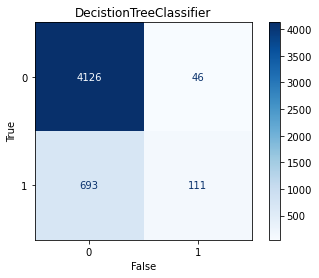

In [34]:
# View confusion matrix

plot_confusion_matrix(grid, X_test, y_test, cmap='Blues', values_format='d');
plt.title("DecistionTreeClassifier")
plt.xlabel('False')
plt.ylabel('True')
plt.show()

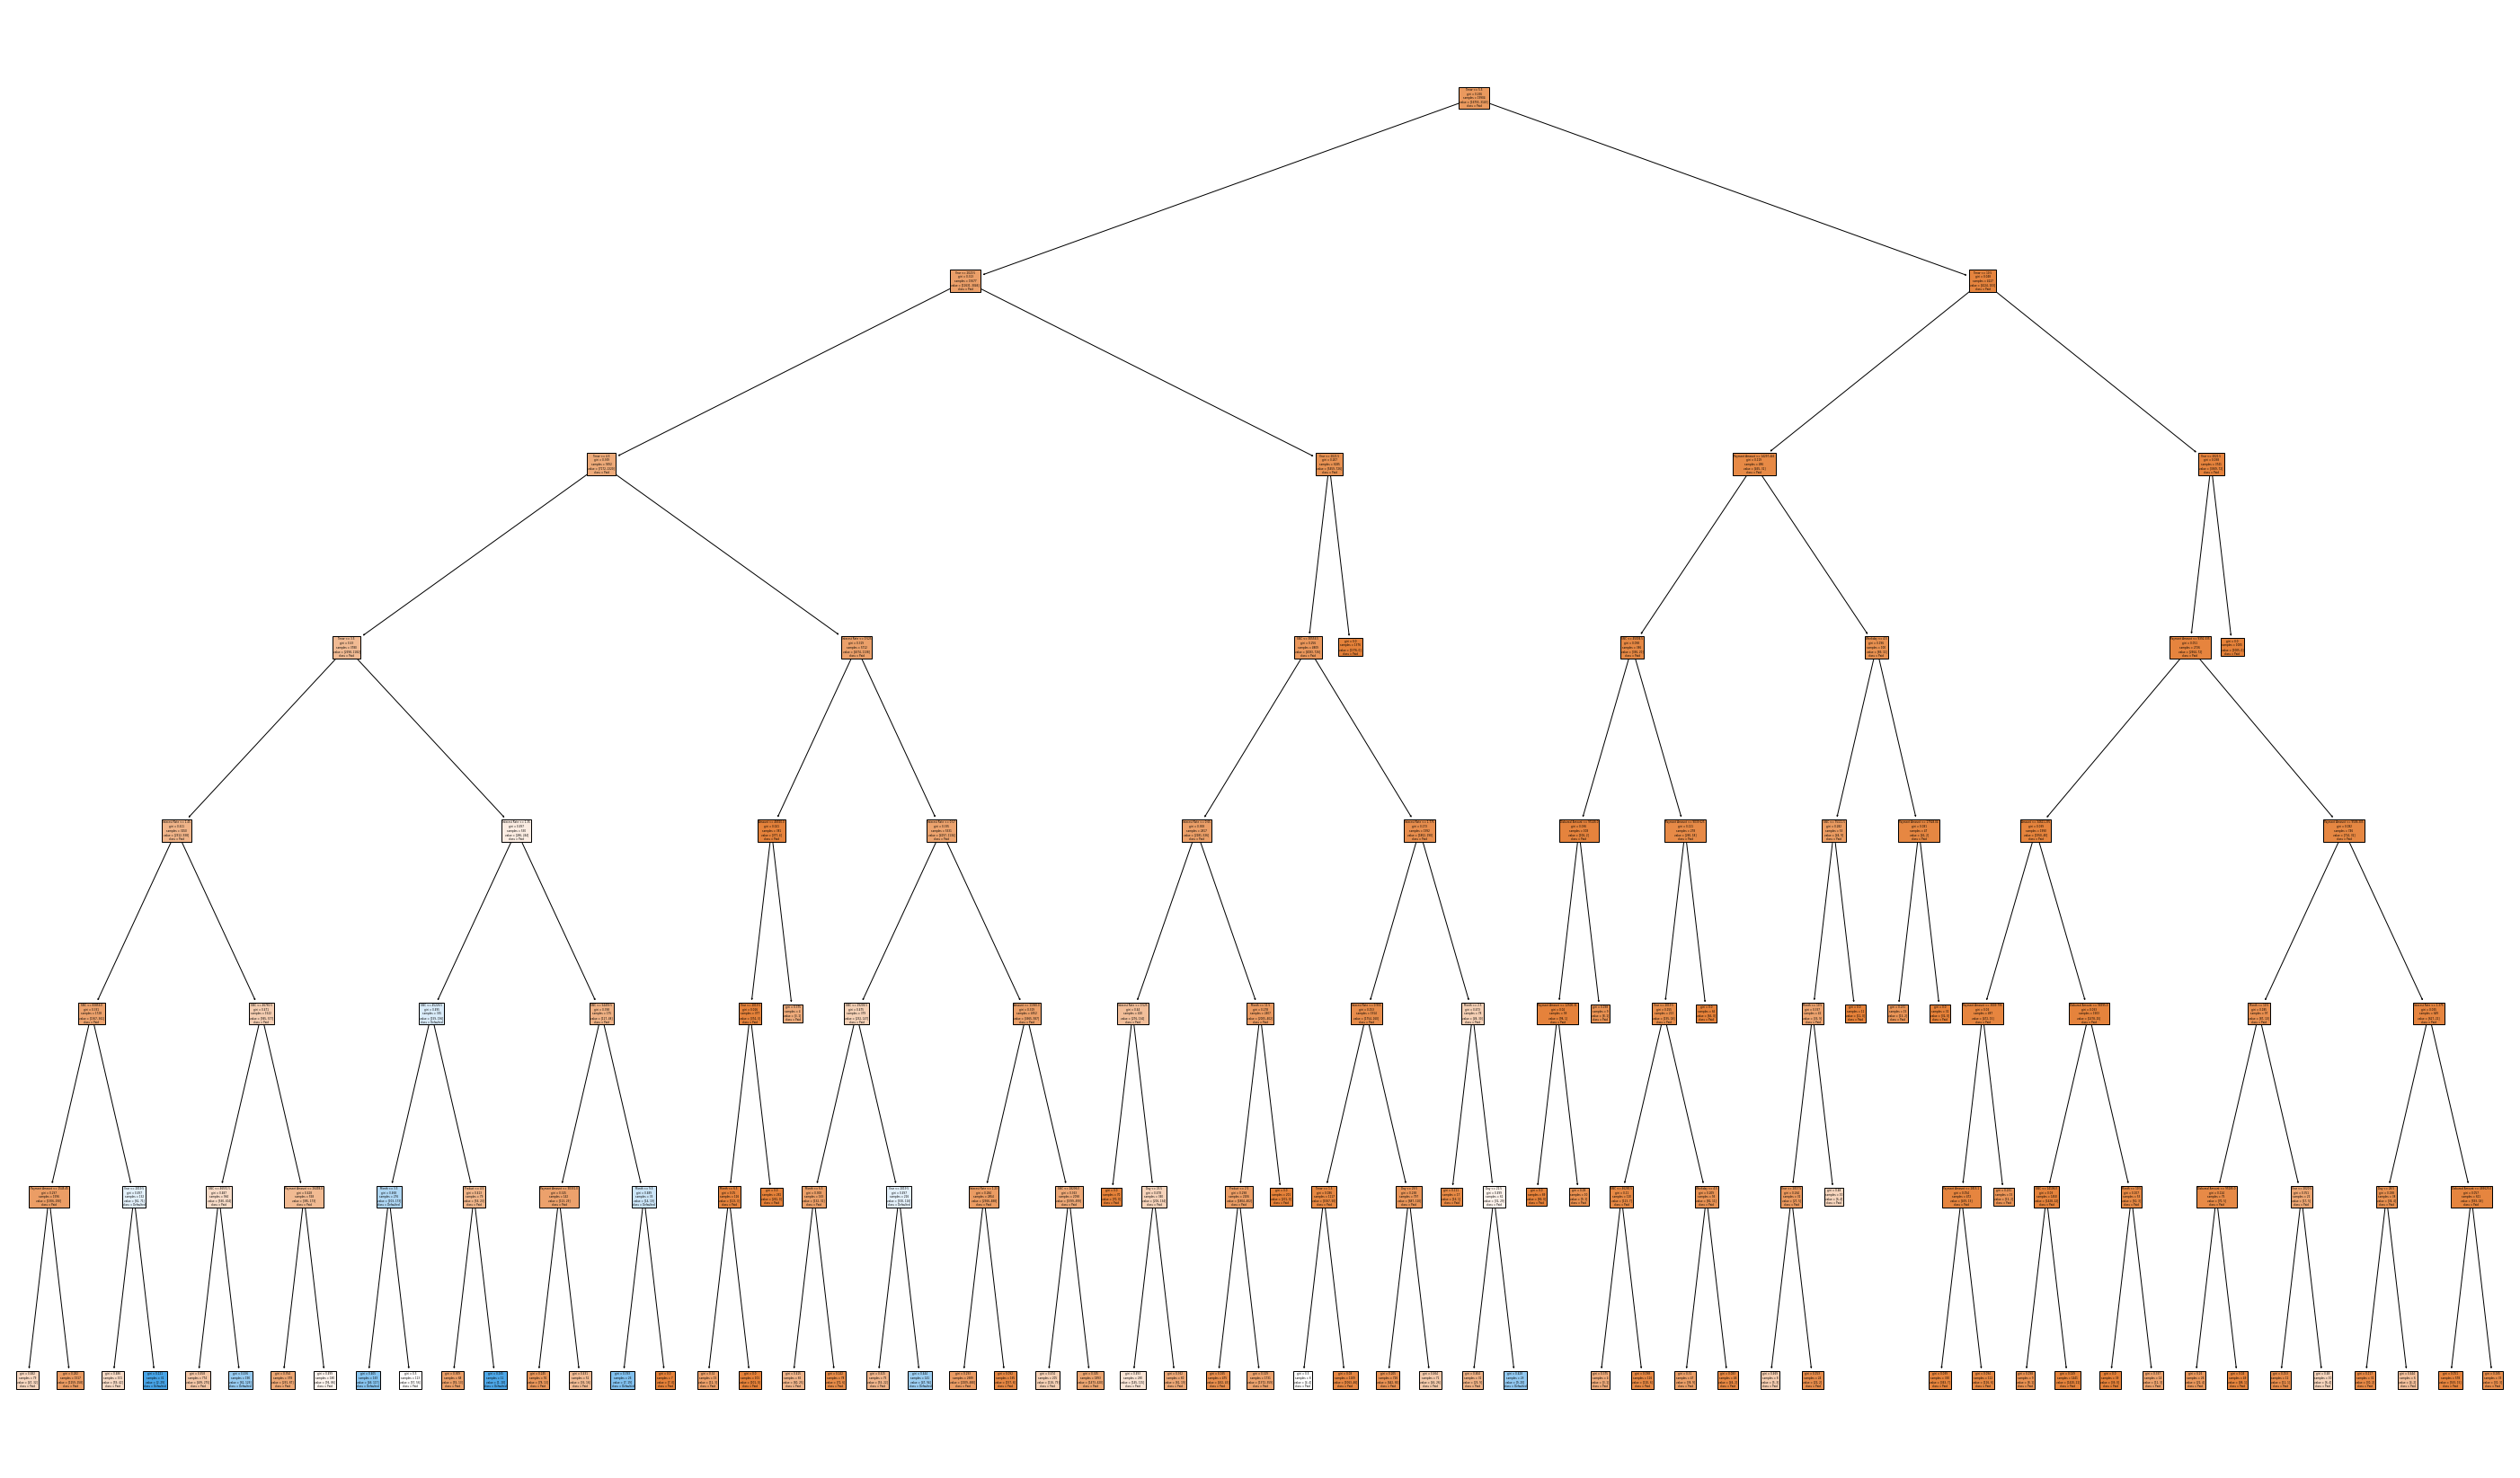

In [35]:
# Import plot_tree from sklearn.tree module.
from sklearn.tree import plot_tree

# Establish size of figure.
plt.figure(figsize = (50, 30))

# Plot our tree.
plot_tree(grid.best_estimator_,
          feature_names = X_train.columns,
          class_names = ['Paid', 'Defaulted'],
          filled = True);

In [36]:
#text_representation = tree.export_text(grid.best_estimator_)
#print(text_representation)

Baseline: ROC AUC=0.500
DecisionTree: ROC AUC=0.703


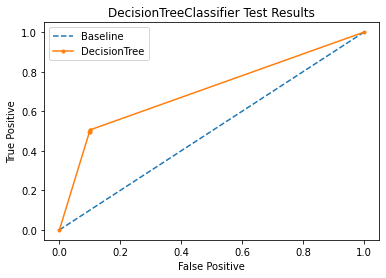

In [37]:
# ROC Curve

base_probs = [0 for _ in range(len(y_test))]
model_probs = prob[:,1]

# Calculate scores
base_auc = roc_auc_score(y_test, base_probs)
auc = roc_auc_score(y_test, model_probs)

# Summarize scores
print('Baseline: ROC AUC=%.3f' % (base_auc))
print('DecisionTree: ROC AUC=%.3f' % (auc))

# Calculate roc curves
base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)
model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)

# Plot roc curve for the model
plt.plot(base_fpr, base_tpr, linestyle='--', label='Baseline')
plt.plot(model_fpr, model_tpr, marker='.', label='DecisionTree')

# Title
plt.title('DecisionTreeClassifier Test Results')

# Axis labels
plt.xlabel('False Positive')
plt.ylabel('True Positive')

# Legend
plt.legend()

plt.show()
